# Anomaly detection with n-sigma on z-score

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [3]:
import sys
sys.path.append("../")

from meltria import loader

In [4]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

from meltria.priorknowledge.priorknowledge import SockShopKnowledge

sockshop_pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewares": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

In [5]:
metrics_files = !find "/datasets/argowf-chaos-{SOCKSHOP_DATASET_ID}/" -type f -name "*.json"
records = loader.load_dataset(metrics_files, target_metric_types={
        "containers": True,
        "services": True,
        "nodes": True,
        "middlewares": True,
    },
    num_datapoints=4*45, # 45min
)

In [6]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    SOCKSHOP_DATASET_ID, 
    metric_types={
        "services": True,
        "containers": True,
        "middlewares": True,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    use_manually_selected_metrics=False,
)

In [24]:
import pandas as pd

record, data_df_by_metric_type = dataset_by_chaos[("pod-memory-hog", "payment")][0]
dataset = pd.concat([
    data_df_by_metric_type["containers"][0],
    data_df_by_metric_type["services"][0],
    # data_df_by_metric_type["middlewares"][0],
], axis=1)
dataset.shape

(180, 179)

In [30]:
import numpy as np
import scipy.stats

COEFF = scipy.stats.norm.ppf(0.75) - scipy.stats.norm.ppf(0.25)

def zscore_nsigma(train: np.ndarray, test: np.ndarray, n_sigmas: float = 3.0) -> tuple[np.ndarray, np.ndarray]:
    mu, sigma = np.mean(train), np.std(train)
    if sigma == 0.0:
        sigma = 1.0
    scores = np.abs((test - mu) / sigma)
    anomalies = test[scores > n_sigmas]
    return anomalies, scores


def robust_zscore_nsigma(
    train: np.ndarray, test: np.ndarray, test_start_time: int, n_sigmas: float = 3.0
) -> tuple[np.ndarray, np.ndarray]:
    iqr = np.quantile(train, 0.75) - np.quantile(train, 0.25)
    niqr = iqr / COEFF
    median = np.median(train)
    scores = np.abs(test - median)
    anomalies = test[scores > niqr * n_sigmas]
    return anomalies, scores


def detect_anomalies_with_zscore_nsigma(
    x: np.ndarray,
    anomalous_start_idx: int,
    n_sigmas: float = 3.0,
    robust: bool = False,
) -> tuple[bool, float]:
    test_start_idx = x.shape[0] - (anomalous_start_idx + 1)
    train, test = x[:test_start_idx], x[test_start_idx:]
    if robust:
        alarms, scores = robust_zscore_nsigma(train, test, test_start_idx, n_sigmas)
    else:
        alarms, scores = zscore_nsigma(train, test, n_sigmas)
    return alarms.size > 0, scores.max()


In [33]:
# iterate dataset and detect anomalies
from joblib import Parallel, delayed

def _detect(x, label, anomalous_start_idx):
    is_anomaly, score = detect_anomalies_with_zscore_nsigma(x, anomalous_start_idx=anomalous_start_idx, n_sigmas=3.0, robust=True)
    return (label, is_anomaly, x)

results: list[tuple[str, bool, np.ndarray]] = Parallel(n_jobs=-1)(
    delayed(_detect)(content.values, label, anomalous_start_idx=90)
    for label, content in dataset.items()
)

In [34]:
results_df = pd.DataFrame(results, columns=["metric", "is_anomaly", "values"])
# display the ratio of normal and abnormal data
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(results_df.groupby("is_anomaly").count())
    display(results_df.sample(n=min(200, results_df.shape[0])).sort_values("is_anomaly"))

metric  values
is_anomaly                
False            7       7
True           172     172

metric  is_anomaly  \
98                c-orders-db_fs_reads_bytes_total       False   
116                       c-orders-db_memory_cache       False   
30                   c-carts-db_memory_usage_bytes       False   
101                     c-orders-db_fs_reads_total       False   
115                 c-orders-db_memory_usage_bytes       False   
118                      c-user-db_fs_writes_total       False   
70        c-orders_cpu_cfs_throttled_periods_total       False   
129          c-user-db_network_receive_bytes_total        True   
62     c-front-end_cpu_cfs_throttled_seconds_total        True   
93             c-shipping_cpu_system_seconds_total        True   
38                           c-catalogue_last_seen        True   
72                c-orders_cpu_usage_seconds_total        True   
50                        c-catalogue-db_last_seen        True   
163                      c-user_memory_usage_bytes        True   
60      c-front-end_network_transmit_packets_total        True   
49     c-catalogue-db_network_transmit_bytes_total        True   
53         c-catalogue-db_cpu_system_seconds_total        True   
100           c-orders-db_blkio_device_usage_total        True   
5                               c-carts_memory_rss        True   
104              c-orders-db_fs_writes_bytes_total        True   
165                                s-carts_latency        True   
79               c-orders_cpu_system_seconds_total        True   
15               c-carts-db_cpu_user_seconds_total        True   
140              c-payment_cpu_usage_seconds_total        True   
48                       c-catalogue-db_memory_rss        True   
145          c-payment_network_receive_bytes_total        True   
166                         s-catalogue_throughput        True   
99              c-orders-db_cpu_user_seconds_total        True   
112      c-orders-db_network_receive_packets_total        True   
147             c-payment_cpu_system_seconds_total        True   
34            c-catalogue_memory_working_set_bytes        True   
102    c-orders-db_cpu_cfs_throttled_periods_total        True   
121      c-user-db_cpu_cfs_throttled_periods_total        True   
113           c-orders-db_cpu_system_seconds_total        True   
89      c-shipping_cpu_cfs_throttled_seconds_total        True   
71               c-orders_memory_working_set_bytes        True   
88                           c-shipping_memory_rss        True   
159            c-user_network_transmit_bytes_total        True   
152                   c-user_cpu_cfs_periods_total        True   
123                c-user-db_fs_writes_bytes_total        True   
169                             s-front-end_errors        True   
111        c-orders-db_network_receive_bytes_total        True   
56              c-front-end_cpu_user_seconds_total        True   
167                            s-catalogue_latency        True   
106     c-orders-db_network_transmit_packets_total        True   
168                         s-front-end_throughput        True   
81                     c-orders_memory_usage_bytes        True   
69                 c-orders_cpu_user_seconds_total        True   
57     c-front-end_cpu_cfs_throttled_periods_total        True   
176                             s-shipping_latency        True   
4           c-carts_network_transmit_packets_total        True   
170                            s-front-end_latency        True   
25         c-carts-db_network_transmit_bytes_total        True   
144         c-payment_network_transmit_bytes_total        True   
27        c-carts-db_network_receive_packets_total        True   
68                  c-orders_cpu_cfs_periods_total        True   
1                   c-carts_cpu_user_seconds_total        True   
84      c-shipping_cpu_cfs_throttled_periods_total        True   
154         c-user_cpu_cfs_throttled_periods_total        True   
127      c-user-db_cpu_cfs_throttled_seconds_total        True   
21              c-

In [28]:
from eval.groundtruth import check_cause_metrics
from eval.tsdr import recall_of_cause_metrics

def calc_recall(results_df, record, optional_cause=False):
    anomalous_metrics = results_df.query("is_anomaly == True")["metric"].values.tolist()
    _, found_cause_metrics = check_cause_metrics(record.pk, anomalous_metrics, record.chaos_type(), record.chaos_comp(), optional_cause=optional_cause)
    _, total_cause_metrics = check_cause_metrics(record.pk, dataset.columns.tolist(), record.chaos_type(), record.chaos_comp(), optional_cause=optional_cause)
    diff_cause_metrics = set(total_cause_metrics) - set(found_cause_metrics)
    return recall_of_cause_metrics(set(total_cause_metrics), set(found_cause_metrics.tolist())), diff_cause_metrics

print(calc_recall(results_df, record, optional_cause=False))
recall, diff = calc_recall(results_df, record, optional_cause=True)
print(recall, diff)
if len(diff) > 0:
    dataset[list(diff)].plot(subplots=True)

(1.0, set())
1.0 set()


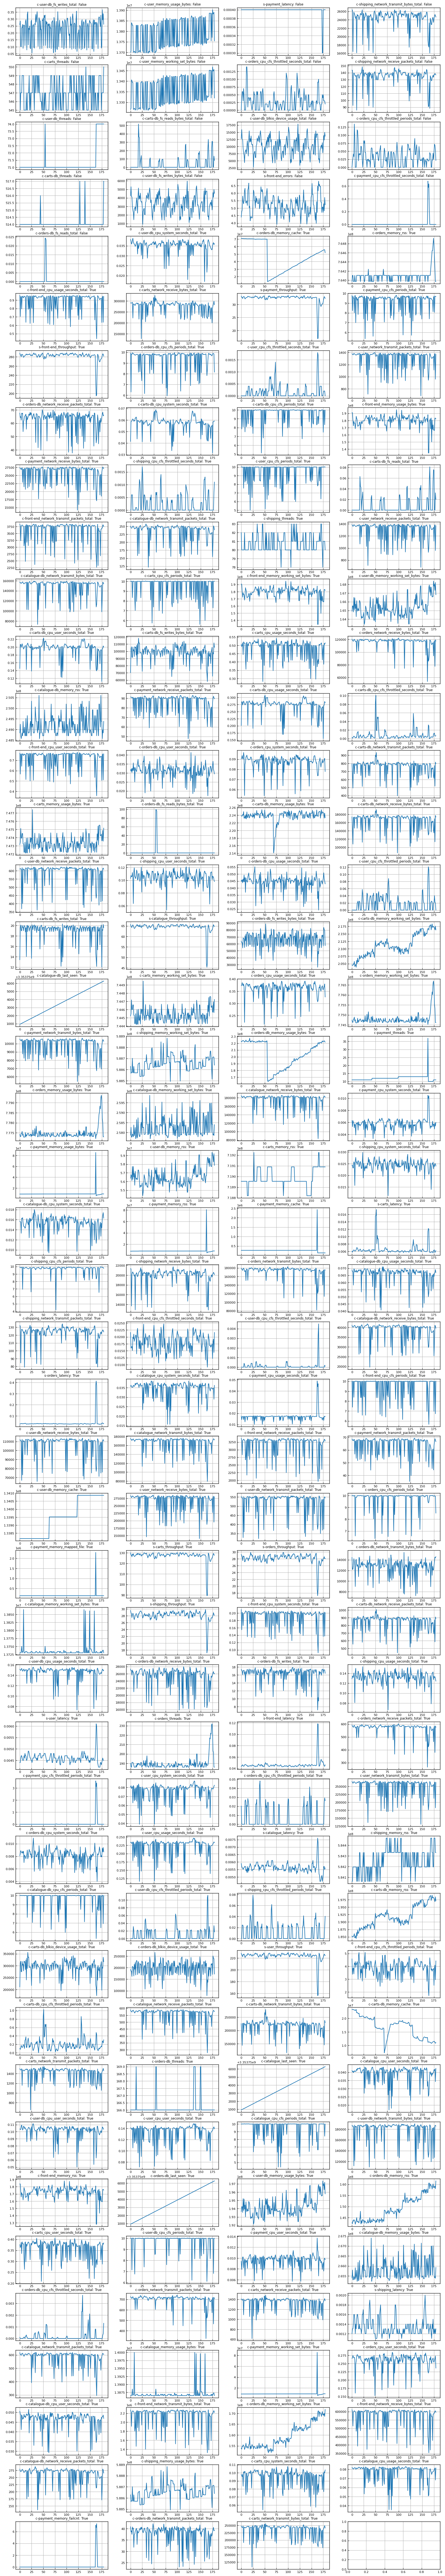

In [29]:
import math

_results_df = results_df.sample(n=min(200, results_df.shape[0]))
ncols = 4
nrows = math.ceil(_results_df.shape[0] / ncols)
fig, axs = plt.subplots(figsize=(20, 2.7 * nrows), nrows=nrows, ncols=ncols)
for (index, data), ax in zip(_results_df.sort_values("is_anomaly").iterrows(), axs.flatten()):  # type: ignore
    ax.plot(data["values"])
    ax.set_title(f"{data['metric']}: {data['is_anomaly']}")